In [1]:
from scipy.io import loadmat
from torch.utils.data import Dataset
from torch import nn
import torch
from torch.utils.data import DataLoader
import numpy as np
import random
import torchvision.utils as vutils
import matplotlib.pyplot as plt


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)

In [3]:
mnist = loadmat("../mnist-original.mat/mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

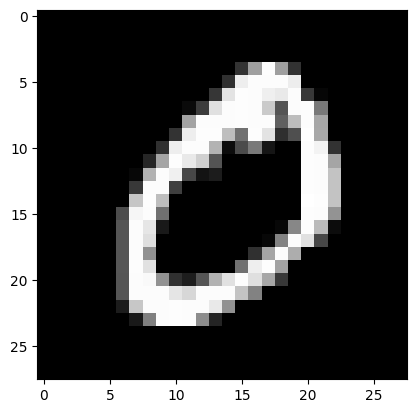

In [4]:
plt.imshow(mnist_data[0].reshape(28, 28), cmap="gray")

In [5]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
class MNISTDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(self.data[idx]), self.label[idx]



In [7]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(ConvVAE, self).__init__()
        
        # Encoder: Convolutions to extract features
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # (B, 64, 16, 16)
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # (B, 128, 8, 8)
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # (B, 256, 4, 4)
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256)
        )
        
        # Latent space
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        
        # Decoder: Transposed convolutions for upsampling
        self.decoder_input = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # (B, 64, 8, 8)
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # (B, 32, 16, 16)
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1), # (B, 3, 32, 32)
            nn.Sigmoid()  # Output pixel values between 0 and 1
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), 256, 4, 4)  # Reshape to feature maps
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar
    
    
def get_model_size(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


        

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [9]:
mnist_data = mnist_data.reshape(-1, 28, 28)
datset = MNISTDataset(mnist_data, mnist_label,transform)

In [10]:
def loss_function(recon_x, x, mu, logvar, lamda=1):
    rec_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # rec_loss = nn.BCELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return rec_loss + lamda*KLD, rec_loss.item(), KLD.item()

In [11]:
latent_dim = 16
dataloader = DataLoader(datset, batch_size=128, shuffle=True, num_workers=4)
model = ConvVAE(latent_dim).to(device)
model_size = get_model_size(model)
print(f'model size: {model_size*4/1024/1024}M')



model size: 5.780887603759766M


In [12]:
training_losses = []
rec_losses = []
kl_losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 200
model.train()
for epoch in range(epochs):
    epoch_loss = []
    rec_epoch_loss = []
    kl_epoch_loss = []
    for i, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        data = nn.functional.pad(data, (2, 2, 2, 2), value=0)
        recon_data, mu, logvar = model(data)
        loss, rec_loss, kl_loss = loss_function(recon_data, data, mu, logvar, 0.1)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        rec_epoch_loss.append(rec_loss)
        kl_epoch_loss.append(kl_loss)
    print(f'epoch: {epoch}, loss: {sum(epoch_loss)/len(epoch_loss)}')
    training_losses.append(sum(epoch_loss)/len(epoch_loss))
    rec_losses.append(sum(rec_epoch_loss)/len(rec_epoch_loss))
    kl_losses.append(sum(kl_epoch_loss)/len(kl_epoch_loss))
    

epoch: 0, loss: 3396.384358128856
epoch: 1, loss: 1734.2098000367773
epoch: 2, loss: 1585.6194778247116
epoch: 3, loss: 1507.8744557047676
epoch: 4, loss: 1445.8361013018452
epoch: 5, loss: 1396.1287609707067
epoch: 6, loss: 1361.9019052341607
epoch: 7, loss: 1331.3784764375287
epoch: 8, loss: 1310.83610844307
epoch: 9, loss: 1285.319907235489
epoch: 10, loss: 1265.4071901868858
epoch: 11, loss: 1248.5184071765739
epoch: 12, loss: 1232.059845026494
epoch: 13, loss: 1215.3509802670103
epoch: 14, loss: 1202.1902618687157
epoch: 15, loss: 1189.9789724402278
epoch: 16, loss: 1182.3376179194756
epoch: 17, loss: 1172.0124859853463
epoch: 18, loss: 1165.8439106775595
epoch: 19, loss: 1153.7012085853592
epoch: 20, loss: 1152.1867100019995
epoch: 21, loss: 1142.8983185539735
epoch: 22, loss: 1136.8987135529735
epoch: 23, loss: 1131.3977352051675
epoch: 24, loss: 1124.1122448797419
epoch: 25, loss: 1119.421840074947
epoch: 26, loss: 1114.6724187373243
epoch: 27, loss: 1112.024029217429
epoch: 28

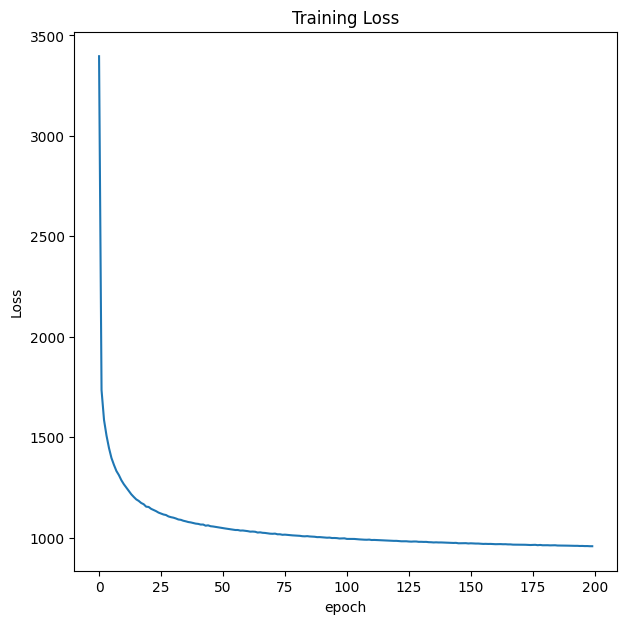

In [18]:
plt.figure(figsize=(7, 7))
plt.plot(training_losses)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

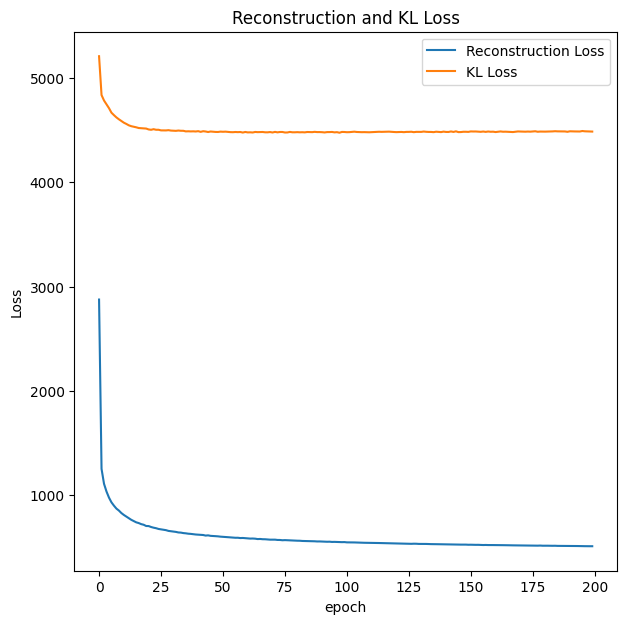

In [19]:
plt.figure(figsize=(7, 7))
plt.plot(rec_losses, label='Reconstruction Loss')
plt.plot(kl_losses, label='KL Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Reconstruction and KL Loss')
plt.legend()
plt.show()

In [20]:
def show_images(images):
    grid = vutils.make_grid(images, nrow=4, padding=2, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).cpu(), cmap='gray')  # 调整维度顺序
    plt.axis('off')
    plt.show()
    plt.close()

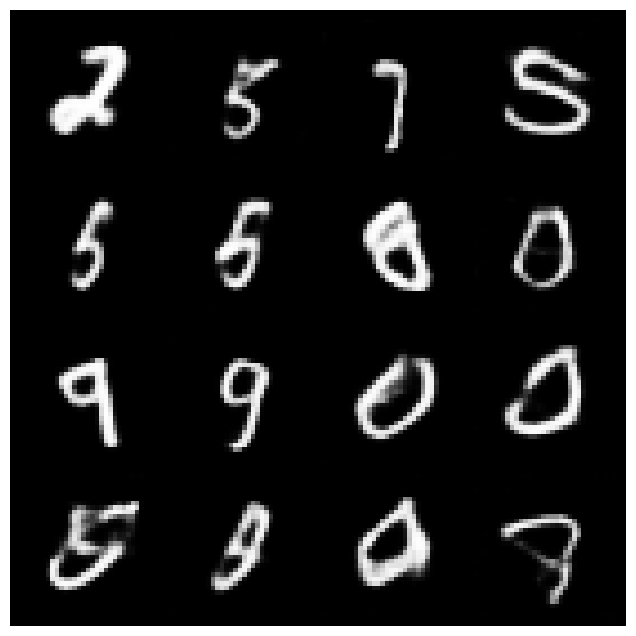

In [21]:

# 修改输入数据维度为16
test_data = torch.randn(16, 1, latent_dim).to(device)  # 修改第一维度为16

with torch.no_grad():
    model.eval()
    output = model.decode(test_data)
    show_images(output)


alphas: tensor([0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571, 1.0000],
       device='cuda:0')
torch.Size([8, 16])
torch.Size([1, 1, 32, 32])


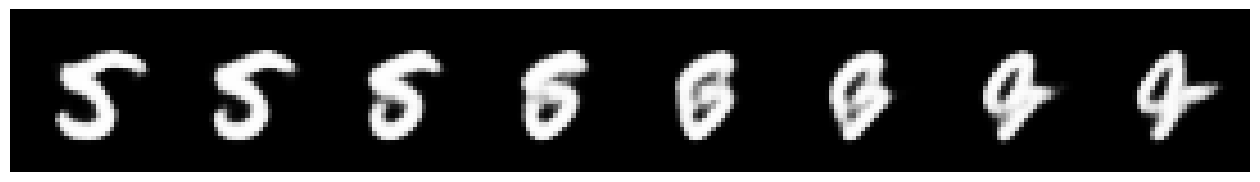

torch.Size([8, 16])
torch.Size([1, 1, 32, 32])


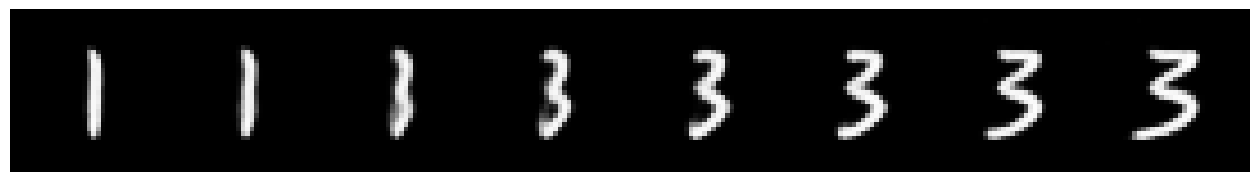

torch.Size([8, 16])
torch.Size([1, 1, 32, 32])


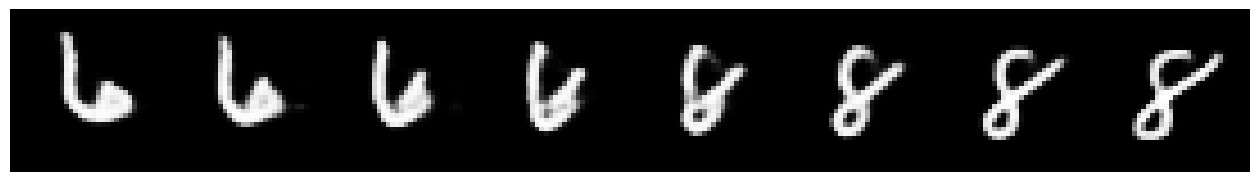

torch.Size([8, 16])
torch.Size([1, 1, 32, 32])


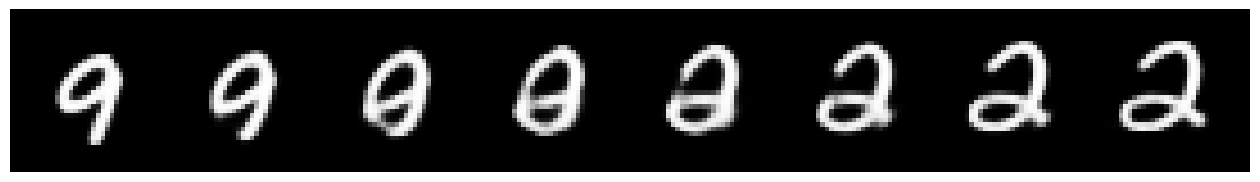

In [32]:
test_dataloader = DataLoader(datset, batch_size=16, shuffle=True)

alphas = torch.linspace(0, 1, 8).to(device)
print(f'alphas: {alphas}')
with torch.no_grad():
    model.eval()
    for i, (data, _) in enumerate(test_dataloader):
        data = data.to(device)
        data = nn.functional.pad(data, (2, 2, 2, 2), value=0)
        _, mu, logvar = model(data)
        latent_var = model.reparameterize(mu, logvar)
        for i in range(8):
            if i % 2 == 0:
                continue
            interpolated_z = torch.stack([(1 - a) * latent_var[i] + a * latent_var[i+1] for a in alphas])
            print(interpolated_z.shape)
            output = model.decode(interpolated_z)
            print(data[i:i+1].shape)
            grid = vutils.make_grid(output, nrow=8, padding=2, normalize=True)
            plt.figure(figsize=(16,16))
            plt.imshow(grid.permute(1, 2, 0).cpu(), cmap='gray')  # 调整维度顺序
            plt.axis('off')
            plt.show()
            plt.close()
        break

    